In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
%cd /content/gdrive/MyDrive/Borealis TechTonics/

/content/gdrive/MyDrive/Borealis TechTonics


In [53]:
# EDA and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# training CNN using pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
df = pd.read_csv('chunk2.csv')

<ipython-input-29-c1d741d68470>:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('chunk2.csv')


In [30]:
df.head()

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,17.080000,...,None,None,0.92,102.09,159.3,[56.79999924 55.40000153 47.40000153],[[2896.]],2006-07-23 15:59:01,earthquake_local,109C.TA_20060723155859_EV
1,TA,109C,BH,32.8889,-117.1051,150.0,600.0,manual,0.5,16.879999,...,None,None,0.91,101.34,281.7,[65. 65.5 61.40000153],[[5508.]],2006-11-03 15:56:54,earthquake_local,109C.TA_20061103155652_EV
2,TA,109C,BH,32.8889,-117.1051,150.0,500.0,manual,0.5,17.260000,...,None,None,0.92,101.87,280.5,[37.20000076 42. 38.59999847],[[3114.]],2006-11-03 16:12:25,earthquake_local,109C.TA_20061103161223_EV
3,TA,109C,BH,32.8889,-117.1051,150.0,900.0,manual,0.5,17.280001,...,None,None,0.93,103.26,281.6,[54.09999847 54.90000153 45.5 ],[[3152.]],2006-11-14 13:32:23,earthquake_local,109C.TA_20061114133221_EV
4,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,18.139999,...,None,None,0.92,102.48,4.7,[58.20000076 56.20000076 53.79999924],[[3134.]],2006-11-27 10:46:41,earthquake_local,109C.TA_20061127104640_EV


In [31]:
df.columns

Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'p_travel_sec', 's_arrival_sample', 's_status',
       's_weight', 'source_id', 'source_origin_time',
       'source_origin_uncertainty_sec', 'source_latitude', 'source_longitude',
       'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name'],
      dtype='object')

In [32]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

# Check for missing values
print('Number of missing values:', df.isnull().sum().sum())

Number of rows: 200000
Number of columns: 35
Number of missing values: 79691


In [33]:
num_cols = ['receiver_latitude', 'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
            'p_weight', 'p_travel_sec', 's_arrival_sample', 's_weight', 'source_origin_uncertainty_sec',
            'source_latitude', 'source_longitude', 'source_error_sec', 'source_gap_deg',
            'source_horizontal_uncertainty_km', 'source_depth_km', 'source_depth_uncertainty_km',
            'source_magnitude', 'source_distance_deg', 'source_distance_km', 'back_azimuth_deg',
            'snr_db', 'coda_end_sample']

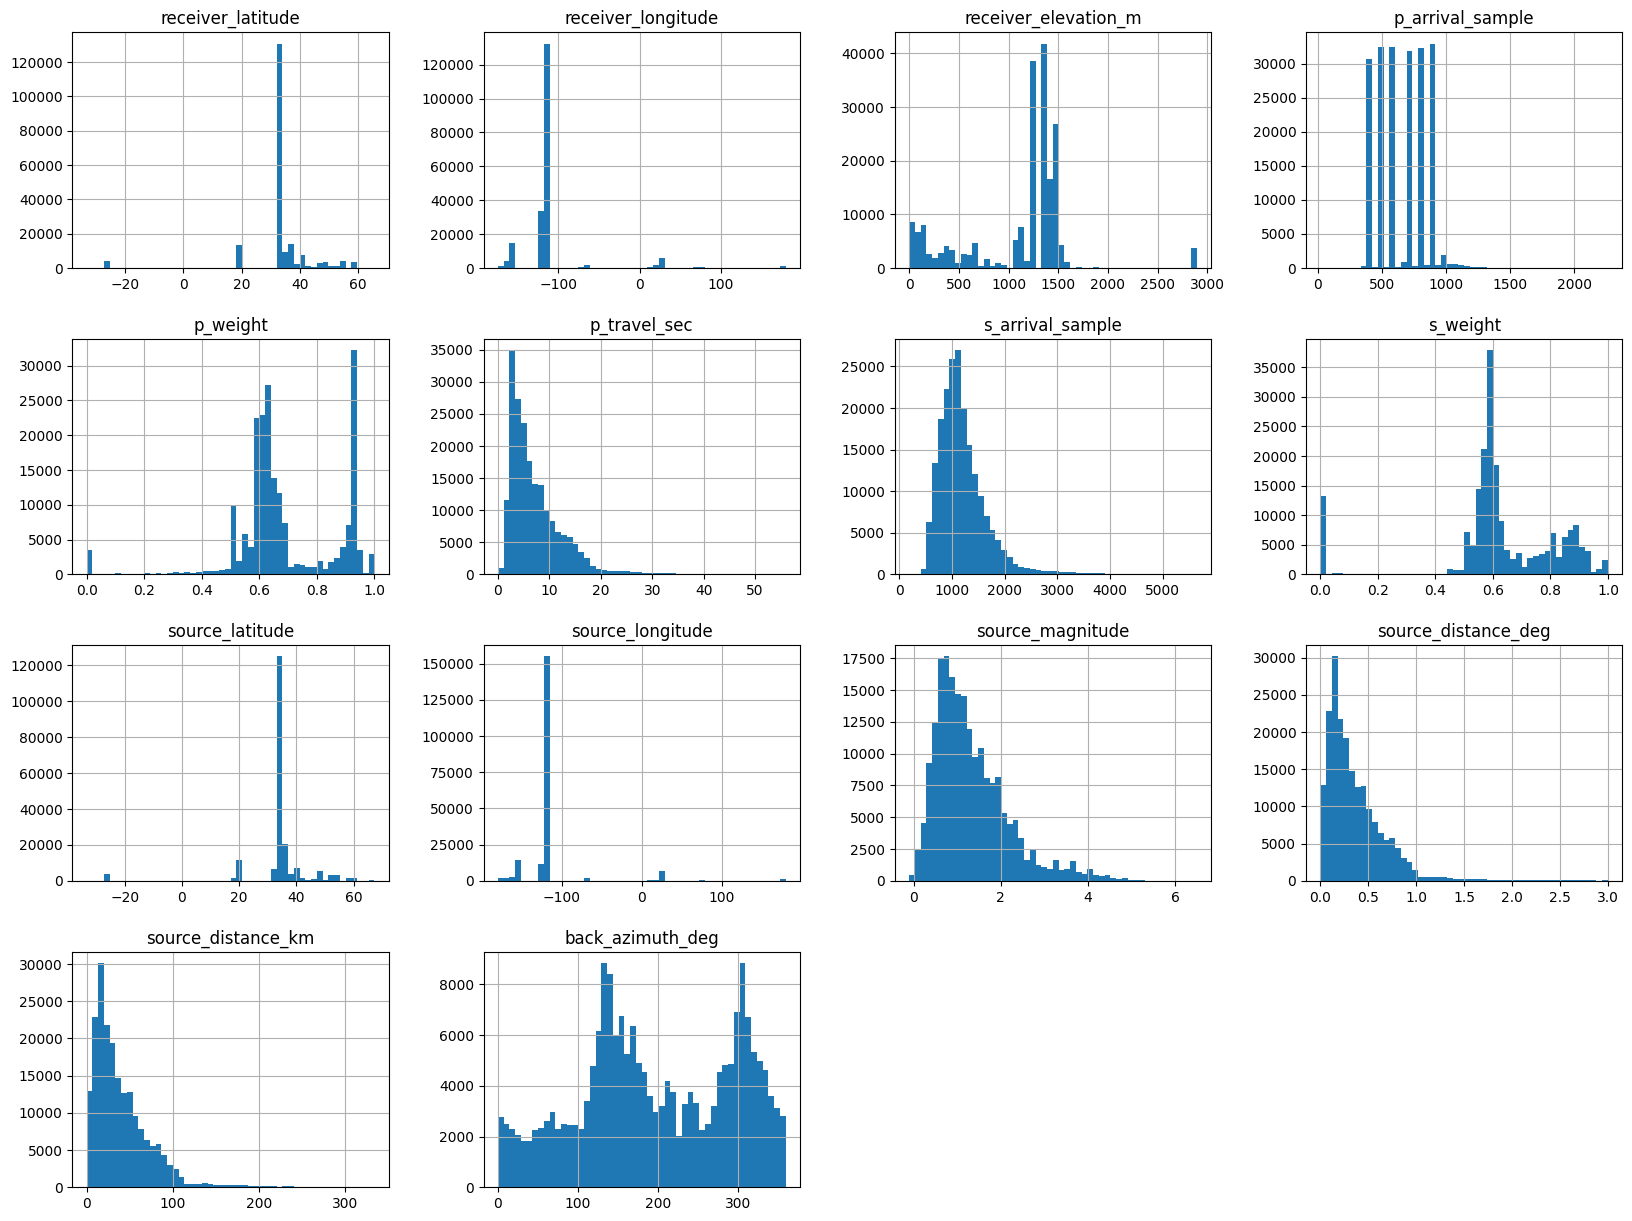

In [34]:
df[num_cols].hist(bins=50, figsize=(20,15))
plt.show()

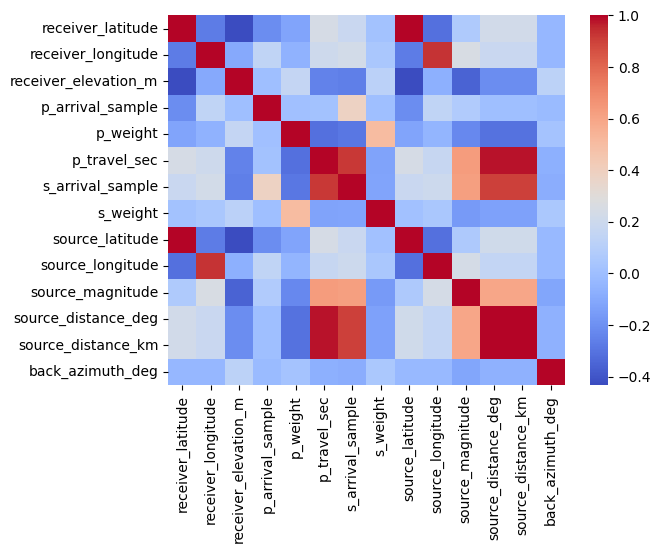

In [36]:
# Check the correlation between numerical columns
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

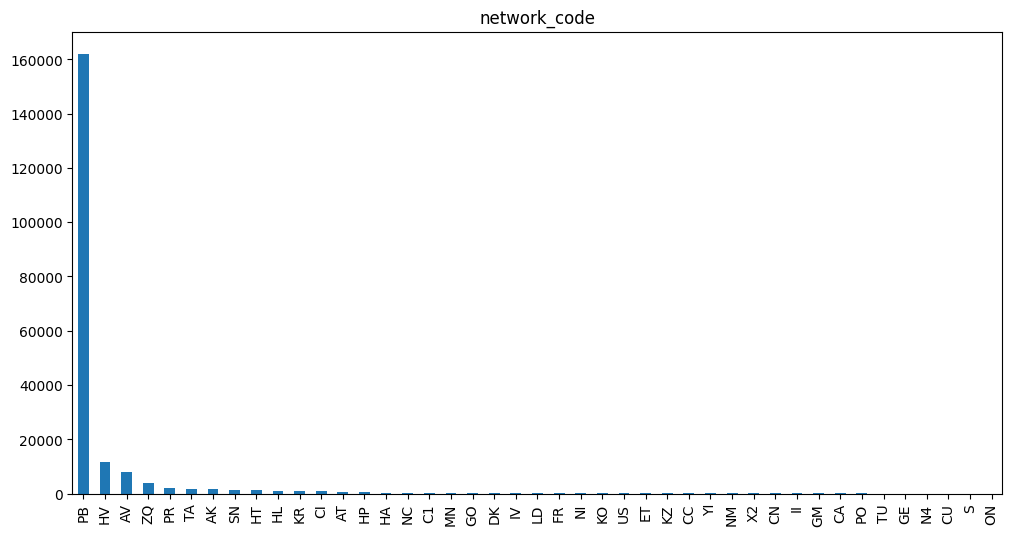

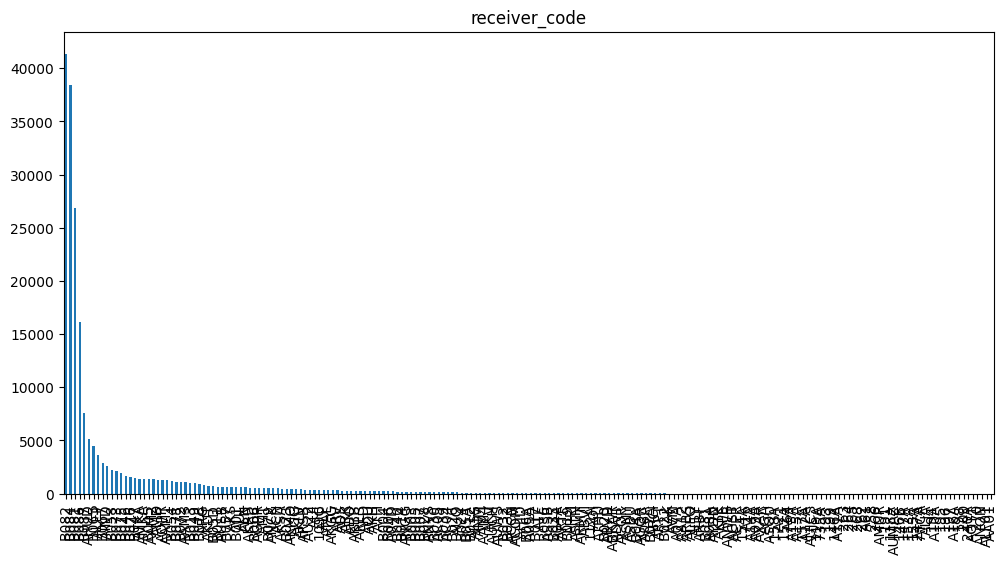

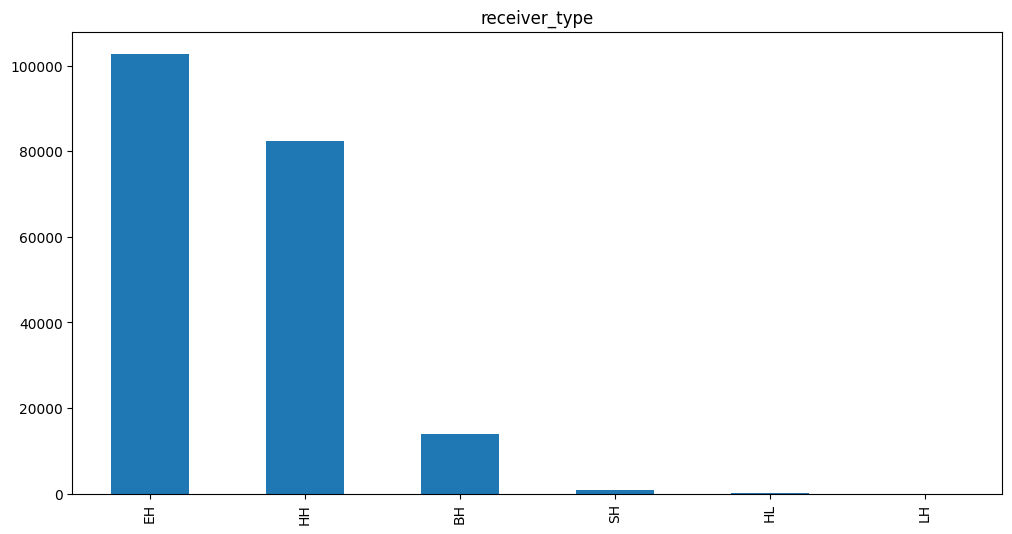

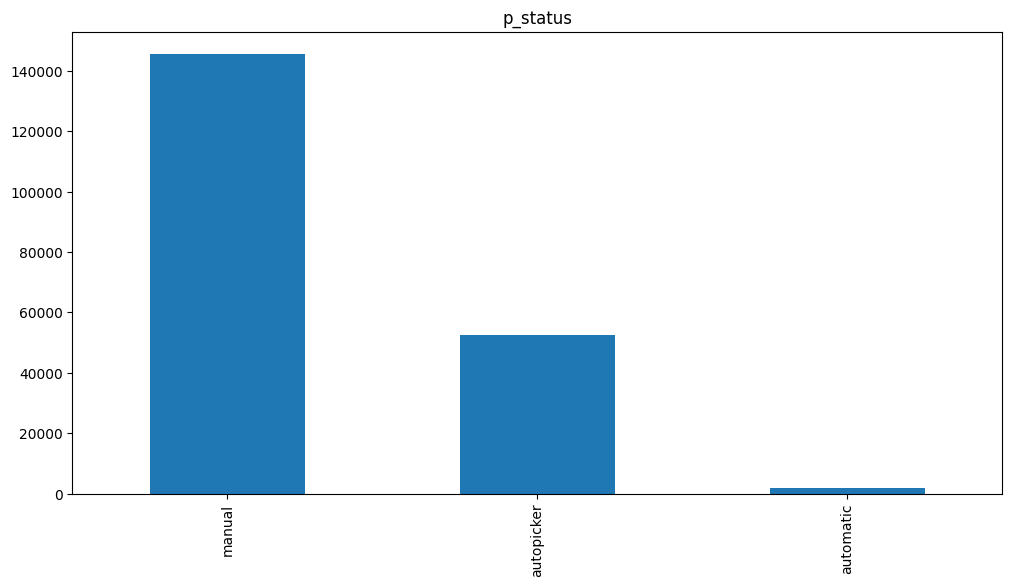

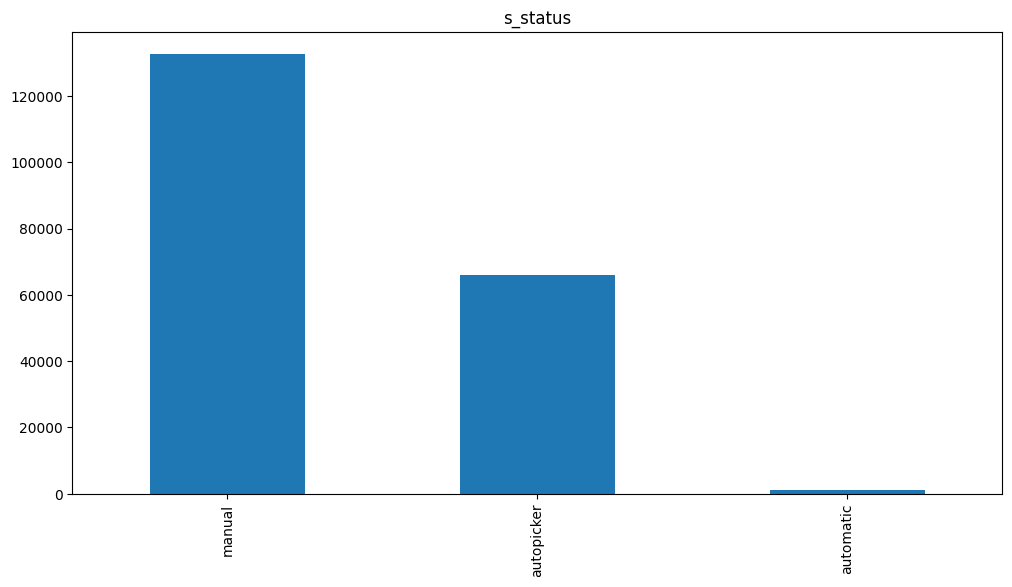

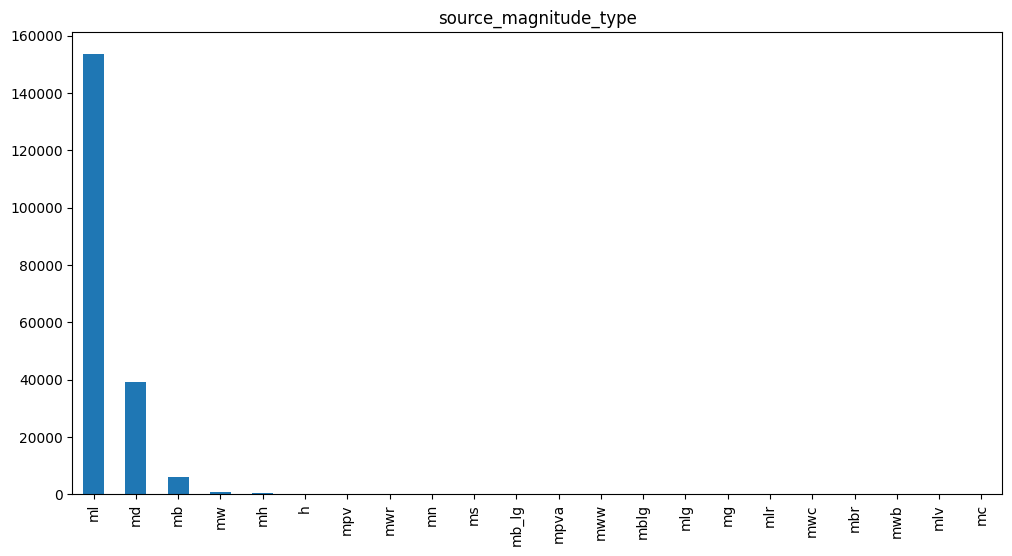

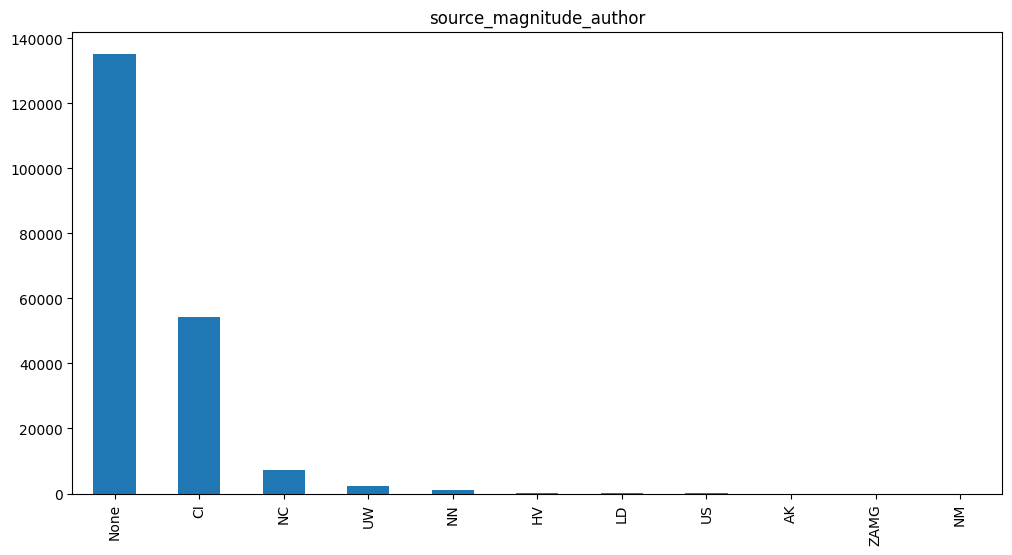

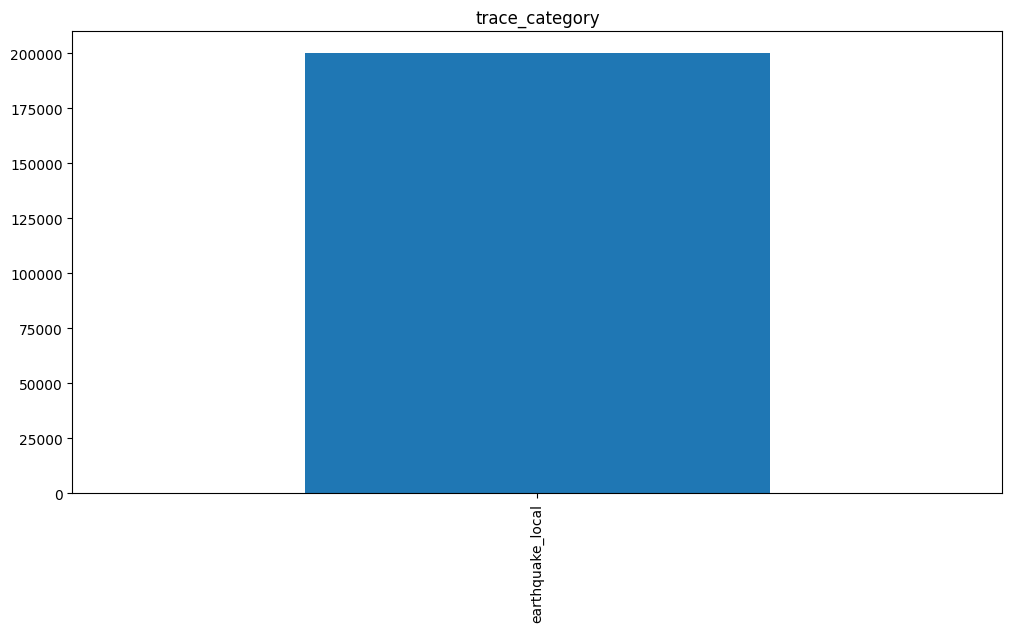

KeyboardInterrupt: ignored

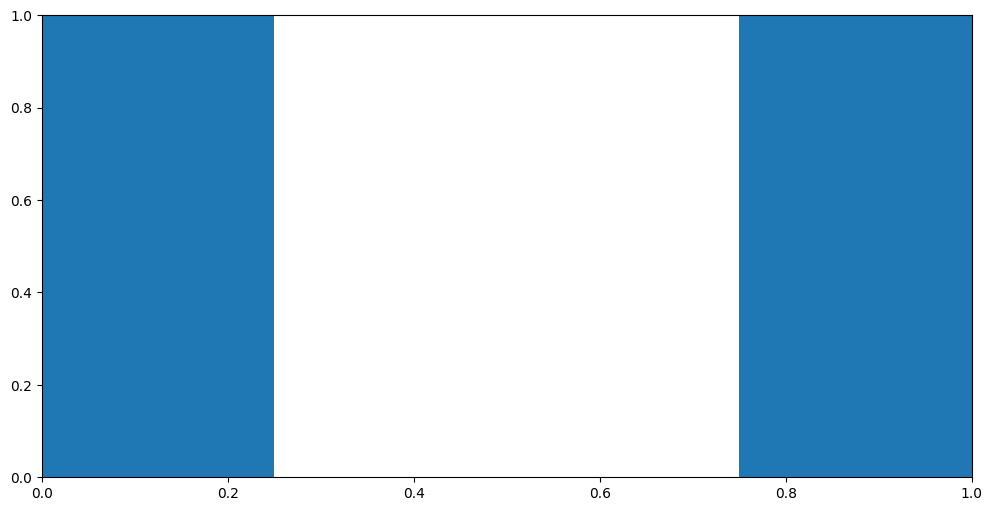

In [37]:
# Check the distribution of categorical columns
cat_cols = ['network_code', 'receiver_code', 'receiver_type', 'p_status', 's_status',
            'source_magnitude_type', 'source_magnitude_author', 'trace_category', 'trace_name']
for col in cat_cols:
    plt.figure(figsize=(12,6))
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

In [41]:
print('Number of duplicate rows:', df.duplicated().sum())
df = df.drop_duplicates()

# Handle missing values
print('Number of rows with missing values:', df.isnull().any(axis=1).sum())
df = df.dropna()



Number of duplicate rows: 0
Number of rows with missing values: 0


In [43]:
# Handle incorrect or inconsistent values
valid_lat_range = (-90, 90)
valid_long_range = (-180, 180)

# Check latitude values
lat_mask = (df['receiver_latitude'] < valid_lat_range[0]) | (df['receiver_latitude'] > valid_lat_range[1])
print('Number of rows with invalid latitude values:', lat_mask.sum())
df = df[~lat_mask]

# Check longitude values
long_mask = (df['receiver_longitude'] < valid_long_range[0]) | (df['receiver_longitude'] > valid_long_range[1])
print('Number of rows with invalid longitude values:', long_mask.sum())
df = df[~long_mask]

Number of rows with invalid latitude values: 0
Number of rows with invalid longitude values: 0
Cleaned dataset:
  network_code receiver_code receiver_type  receiver_latitude  \
0           TA          109C            BH            32.8889   
1           TA          109C            BH            32.8889   
2           TA          109C            BH            32.8889   
3           TA          109C            BH            32.8889   
4           TA          109C            BH            32.8889   

   receiver_longitude  receiver_elevation_m  p_arrival_sample p_status  \
0           -117.1051                 150.0             700.0   manual   
1           -117.1051                 150.0             600.0   manual   
2           -117.1051                 150.0             500.0   manual   
3           -117.1051                 150.0             900.0   manual   
4           -117.1051                 150.0             700.0   manual   

   p_weight  p_travel_sec  ...  source_magnitude_aut

In [46]:
# Print the cleaned dataset
print('Cleaned dataset:')
df.head()
print(f"Shape: {df.shape}")

Cleaned dataset:
Shape: (126523, 35)


In [52]:
data_start = 0 # select start of data rows you want to pull from that chunk
data_end = 12000 # select end of data rows you want to pull from that chunk
data_interval = 2000 # select interval you'd like to pull (smaller interval with more loops may run faster)
# eqpath = eq5_sig_path # select path to data chunk
img_save_path = 'images/waves_long'

img_save_path = 'images/waves_long'
if not os.path.exists(img_save_path):
    os.makedirs(img_save_path)

eqlist = df['trace_name'].to_list() # make a list of the trace names
eqlist = np.random.choice(eqlist,12000,replace=False) # randomly select 12000 trace names so we don't have to run through all 12000

In [51]:
starts = list(np.linspace(data_start,data_end-data_interval,int((data_end-data_start)/data_interval)))
ends = list(np.linspace(data_interval,data_end,int((data_end-data_start)/data_interval)))
set = str(df)

In [ ]:
# Need to download signal wave hdf5.. Error...
# labels care called, trace_category, need to encode them using one hot etc. 
# Features are images called trace_name, need to file_path concat them with file name after hdf5 file, then DONE